In [1]:
import gym
from gym import spaces, error, utils
from gym.utils import seeding
import matplotlib.pyplot as plt
import numpy as np
import copy
import random
%run "solver.py"

In [2]:
N_TUBES = 5
N_COLORS = 4
H_TUBES = 4

DEFAULT_BOARD = [[3,2,1,3],[2,1,1,2],[1,2,3,4],[4,4,0,0],[3,4,0,0]]
arrCompleted = [0]*N_TUBES
Board = copy.deepcopy(DEFAULT_BOARD)
for arr in Board:
    for a in range(len(arr)-1,-1,-1):
        if(arr[a]==0):
            arr.pop(a)

In [3]:
States = {} 
root = Node(None, Board,arrCompleted, N_COLORS, H_TUBES,N_TUBES, (-1, -1), 0, 0)
graph1 = Graph(root)
N_MOVES = graph1.getNeededMoves(root)
States = graph1.generateStates(root,H_TUBES)

In [4]:
class BallSortEnv(gym.Env):
    def __init__(self):
        self.action_space = {}
        count=0
        for i in range(0,N_TUBES): #action space -> generate all possible moves 
            for j in range(0,N_TUBES):
                if (i != j):
                    self.action_space[count] = (i,j)
                    count +=1
        
        self.observation_space = States #observation space -> all possible states
        self.reset()

    def render(self, mode='human'):
        for i in range(len(self.board[0])-1,-1,-1):
            for col in self.board:
                print(col[i]," ",end='')
            print("\n")
        
        
    def step(self, action):
        info = {}
        if(self.checkGameOver()):
            done = True
            reward = (N_MOVES*0.1) + 1.0
            return self.board, reward , done ,info
        else: 
            done = False
            reward = -0.1
        
        if(self.checkValidMove(action)):
            self.moveBall(action)   

        return self.board, reward , done ,info
    
    def reset(self):
        self.board = copy.deepcopy(DEFAULT_BOARD)
        return self.board
    
    def close(self):
        pass
    
    def checkGameOver(self):
        numColsCompleted = 0
        for col in self.board:
            if(col.count(col[0]) == len(col) and col[0] != 0):
                numColsCompleted += 1
        if (numColsCompleted == N_COLORS):
            return True
        else: return False
    
    def checkValidMove(self,move):
        fromCol,toCol = move
        fromIndex = -1
        toIndex = -1
        for number in range(len(self.board[fromCol])-1,-1,-1):
            if(self.board[fromCol][number] != 0):
                fromIndex = number
                break
                    
        for number in range(0,len(self.board[toCol])):
            if(self.board[toCol][number] == 0):
                toIndex = number  
                break
    
        if(fromIndex == -1 or toIndex == -1):
            return False
        
        if(toIndex != 0):
            if(self.board[fromCol][fromIndex] != self.board[toCol][toIndex-1]):
                return False
        
        
        return True
    
    def moveBall(self,move):
        fromCol,toCol = move
        fromIndex = -1
        toIndex = -1
        for number in range(len(self.board[fromCol])-1,-1,-1):
            if(self.board[fromCol][number] != 0):
                fromIndex = number
                break
                    
        for number in range(0,len(self.board[toCol])):
            if(self.board[toCol][number] == 0):
                toIndex = number  
                break
                
        ball = self.board[fromCol][fromIndex]
        self.board[fromCol][fromIndex] = 0
        self.board[toCol][toIndex] = ball
        
def get_key(val,my_dict):
    for key, value in my_dict.items():
         if val == value:
             return key
    return -1
    

In [5]:
env = BallSortEnv()
action_space_size = len(env.action_space)
state_space_size = len(env.observation_space)


In [6]:
#Q-Learning
q_table = np.zeros((state_space_size, action_space_size))

num_episodes = 5000
max_steps_per_episode = 100 # but it won't go higher than 1

learning_rate = 0.1
discount_rate = 0.99

exploration_rate = 1
max_exploration_rate = 1
min_exploration_rate = 0.01

exploration_decay_rate = 0.1 #if we decrease it, will learn slower

In [7]:
#Sarsa

#Defining the different parameters
epsilon = 0.01
total_episodes = 5000
max_steps = 100
alpha = 0.1 #0.85
gamma = 0.99 #0.95
  
#Initializing the Q-matrix
Q = np.zeros((state_space_size, action_space_size))


In [8]:
rewards_all_episodes = []
all_moves_q = []
# Q-Learning algorithm
for episode in range(num_episodes):
    moves_q = 0
    env.reset()
    
    state = 0
    
    done = False
    rewards_current_episode = 0
    
    for step in range(max_steps_per_episode):
        moves_q += 1
        
        # Exploration -exploitation trade-off
        exploration_rate_threshold = random.uniform(0,1)
        if exploration_rate_threshold > exploration_rate:
            numAction = np.argmax(q_table[state,:])
            action = env.action_space[numAction]
        else:
            numAction = random.randint(0,len(env.action_space)-1)
            action = env.action_space[numAction]    
            
            
            
        new_state, reward, done, info = env.step(action)
        new_index = get_key(new_state,env.observation_space)
        
        q_table[state, numAction] = (1 - learning_rate) * q_table[state, numAction] + \
            learning_rate * (reward + discount_rate * np.max(q_table[new_index,:]))
        
        state = new_index
        rewards_current_episode += reward
        
        if done == True:
            break
    all_moves_q.append(moves_q )
    exploration_rate = min_exploration_rate + \
        (max_exploration_rate - min_exploration_rate) * np.exp(-exploration_decay_rate * episode)
    
    rewards_all_episodes.append(rewards_current_episode)
    
# Calculate and print the average reward per 10 episodes
rewards_per_thousand_episodes = np.split(np.array(rewards_all_episodes), num_episodes / 100)
count = 100
print("********** Average  reward per thousand episodes **********\n")

for r in rewards_per_thousand_episodes:
    print(count, ": ", str(sum(r / 100)))
    count += 100
    
# Print updated Q-table
#print("\n\n********** Q-table **********\n")
#for table in range(0,len(q_table)):
    #print(table," : ",q_table[table])
    


for episode in range(2):
    env.reset()
    state = 0
    step = 0
    action = (-1,-1)
    done = False
    print("****************************************************")
    print("EPISODE ", episode,"\n")

    for step in range(max_steps_per_episode):
        
        print("State:",step+1)
        print("Action:",action,"\n")
        env.render()
        print("\n")
        
        # Take the action (index) that have the maximum expected future reward given that state
        numAction = np.argmax(q_table[state,:])
        action = env.action_space[numAction] 
        
        
        new_state, reward, done, info = env.step(action)
        new_index = get_key(new_state,env.observation_space)
        
        if done:
            print("Num Moves:",step)
            break
        state = new_index
        



********** Average  reward per thousand episodes **********

100 :  -9.969999999999969
200 :  -9.94799999999997
300 :  -9.956999999999969
400 :  -9.96099999999997
500 :  -9.84899999999997
600 :  -9.59299999999997
700 :  -8.837999999999973
800 :  -8.050999999999977
900 :  -4.840999999999988
1000 :  0.8690000000000007
1100 :  0.9860000000000007
1200 :  0.9930000000000007
1300 :  0.9910000000000007
1400 :  0.9620000000000006
1500 :  0.9780000000000006
1600 :  0.9900000000000007
1700 :  0.9190000000000007
1800 :  0.9880000000000007
1900 :  0.9850000000000007
2000 :  0.9800000000000006
2100 :  0.9830000000000007
2200 :  0.9870000000000007
2300 :  0.9830000000000007
2400 :  0.9840000000000007
2500 :  0.9820000000000007
2600 :  0.9910000000000007
2700 :  0.8700000000000008
2800 :  0.9870000000000007
2900 :  0.9900000000000007
3000 :  0.9870000000000007
3100 :  0.9880000000000007
3200 :  0.9880000000000007
3300 :  0.9860000000000007
3400 :  0.9870000000000007
3500 :  0.9840000000000007
3600 : 

Text(0, 0.5, 'Rewards')

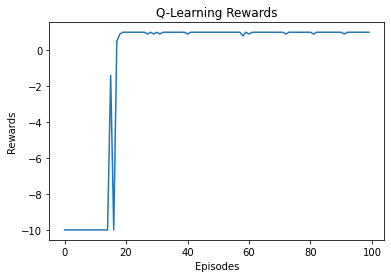

In [14]:
plt.title("Q-Learning Rewards")
plt.plot(rewards_all_episodes[::50])
plt.xlabel('Episodes')
plt.ylabel('Rewards')

Moves


Text(0, 0.5, 'Moves')

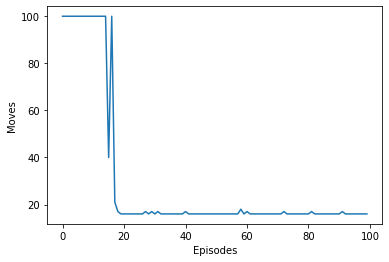

In [10]:
plt.title("Q-Learning Moves")
plt.plot(all_moves_q[::50])
plt.xlabel('Episodes')
plt.ylabel('Moves')

In [11]:
rewards_all_episodes_sarsa = []
all_moves_sarsa  = []

#SARSA


def choose_action(state):
    numAction=0
    if np.random.uniform(0, 1) < epsilon:
        numAction = random.randint(0,len(env.action_space)-1)   
    else:
        numAction = np.argmax(Q[state, :])  
    return numAction

def update(state, state2, reward, action, action2):
    predict = Q[state, action]
    target = reward + gamma * Q[state2, action2]
    Q[state, action] = Q[state, action] + alpha * (target - predict)

# SARSA algorithm
for episode in range(total_episodes):
    env.reset()
    
    moves_sarsa = 0
    state = 0
    numAction1 = choose_action(state)   
    
    done = False
    rewards_current_episode = 0
    
    for step in range(max_steps):
        action1 = env.action_space[numAction1] 
        new_state, reward, done, info = env.step(action1)
        
        moves_sarsa += 1 
        new_index = get_key(new_state,env.observation_space)
        
        # Exploration -exploitation trade-off
        
        numAction2 = choose_action(new_index)
        action2 = env.action_space[numAction2] 
        
        update(state,new_index,reward,numAction1,numAction2)
            
        state = new_index
        numAction1 = numAction2
        
        rewards_current_episode += reward

        if done == True: 
            break
    
    all_moves_sarsa.append(moves_sarsa)
    rewards_all_episodes_sarsa.append(rewards_current_episode)

rewards_per_thousand_episodes = np.split(np.array(rewards_all_episodes_sarsa), total_episodes / 100)
count = 100
print("********** Average  reward per thousand episodes **********\n")

for r in rewards_per_thousand_episodes:
    print(count, ": ", str(sum(r / 100)))
    count += 100

for episode in range(2):
    env.reset()
    state = 0
    step = 0
    action = (-1,-1)
    done = False
    print("****************************************************")
    print("EPISODE ", episode)

    for step in range(max_steps):
        print("State:",step+1)
        print("Action:",action,"\n")
        env.render()
        print("\n")
        
        # Take the action (index) that have the maximum expected future reward given that state
        numAction = np.argmax(q_table[state,:])
        action = env.action_space[numAction] 
        
        
        new_state, reward, done, info = env.step(action)
        new_index = get_key(new_state,env.observation_space)
        
        if done:
            print("Num Moves:",step)
            break
        state = new_index


********** Average  reward per thousand episodes **********

100 :  -9.99999999999997
200 :  -9.99999999999997
300 :  -9.96099999999997
400 :  -9.99999999999997
500 :  -9.900999999999971
600 :  -9.71099999999997
700 :  -9.409999999999972
800 :  -8.634999999999977
900 :  -6.892999999999982
1000 :  -0.37099999999999733
1100 :  0.8750000000000009
1200 :  0.9850000000000007
1300 :  0.8750000000000009
1400 :  0.9850000000000007
1500 :  0.9830000000000007
1600 :  0.9830000000000007
1700 :  0.9850000000000007
1800 :  0.9850000000000007
1900 :  0.9840000000000007
2000 :  0.9880000000000007
2100 :  0.9840000000000007
2200 :  0.9840000000000007
2300 :  0.9780000000000006
2400 :  0.9890000000000007
2500 :  0.9640000000000006
2600 :  0.9870000000000007
2700 :  0.9920000000000007
2800 :  0.9830000000000007
2900 :  0.9810000000000006
3000 :  0.9790000000000006
3100 :  0.9900000000000007
3200 :  0.9820000000000007
3300 :  0.9860000000000007
3400 :  0.9870000000000007
3500 :  0.9820000000000007
3600 :

Text(0, 0.5, 'Rewards')

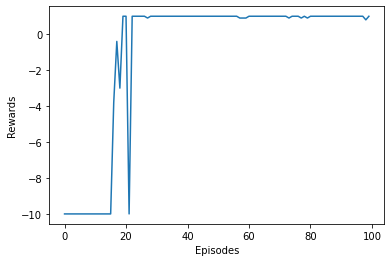

In [12]:
plt.title("Sarsa Rewards")
plt.plot(rewards_all_episodes_sarsa[::50])
plt.xlabel('Episodes')
plt.ylabel('Rewards')

Text(0, 0.5, 'Moves')

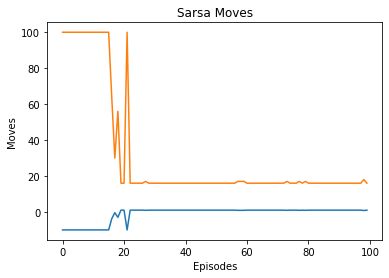

In [15]:
plt.title("Sarsa Moves")
plt.plot(all_moves_sarsa[::50])
plt.xlabel('Episodes')
plt.ylabel('Moves')

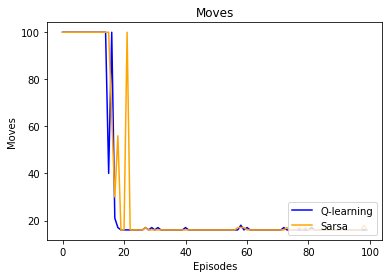

In [24]:
plt.plot(all_moves_q[::50], color="blue")
plt.xlabel('Episodes')
plt.ylabel('Moves')

plt.title("Moves")
plt.plot(all_moves_sarsa[::50], color="orange")
plt.xlabel('Episodes')
plt.ylabel('Moves')
plt.legend(["Q-learning", "Sarsa"], loc ="lower right")

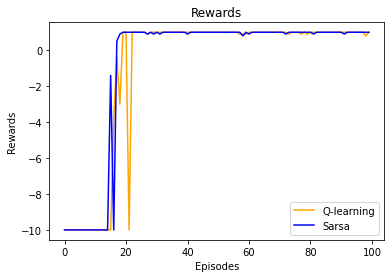

In [23]:
plt.plot(rewards_all_episodes_sarsa[::50], color="orange")
plt.xlabel('Episodes')
plt.ylabel('Rewards')

plt.title("Rewards")
plt.plot(rewards_all_episodes[::50], color="blue")
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.legend([ "Sarsa"m"Q-learning",], loc ="lower right")